In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KernelDensity, KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

from data import make_grid

# Load in Data

<Axes: >

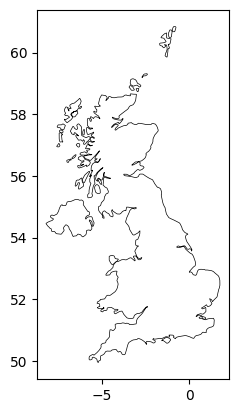

In [2]:
world_map = gpd.read_file("data/source_data/world-administrative-boundaries.geojson")
uk_map = world_map[world_map['iso_3166_1_alpha_2_codes'] == 'GB']

def uk_outline():
    return uk_map.geometry.boundary.plot(color="black", linewidth=0.5)

uk_outline()

In [3]:
grid = make_grid("GB", 0.1).drop(columns=["pop_density"])

Matching birds to grid cells: 

 98%|█████████▊| 98/100 [00:06<00:00, 15.46it/s]/Users/leoware/Documents/ns166_final_analysis/data/make_grid.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  res[spec] = counts
100%|██████████| 100/100 [00:06<00:00, 15.61it/s]


# Sampling Model

In [4]:
id_col = ["lon", "lat"]
cov_col = ['avg_temp', 'avg_min_month', 'avg_max_month']
target_col = grid.columns.difference(id_col + cov_col)

In [18]:
x_d, X, y_d, y = train_test_split(grid[id_col + cov_col], grid[target_col], test_size=0.1, random_state=42)
x_d = x_d[id_col]
y_d = y_d.sum(axis=1)
X = X.drop(columns=id_col)

x_d = pd.DataFrame(x_d.values[y_d < 5000, :], columns=x_d.columns)
y_d = y_d[y_d < 5000]

In [19]:
d_target = np.log(y_d + 1)

sampling_model = RandomForestRegressor()
sampling_model.fit(x_d, y_d)
sampling_model.score(x_d, y_d)

0.8792207489728583

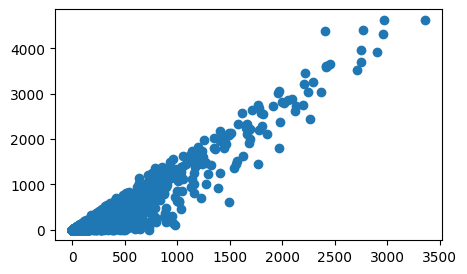

In [20]:
plt.figure(figsize=(5, 3))
plt.plot(sampling_model.predict(x_d), y_d, 'o')

### Visualizing Sampling Density

In [21]:
true_interp = KNeighborsRegressor(n_neighbors=100, p=1)
true_interp.fit(x_d, y_d)

KNeighborsRegressor(n_neighbors=100, p=1)

/Users/leoware/Documents/ns166_final_analysis/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


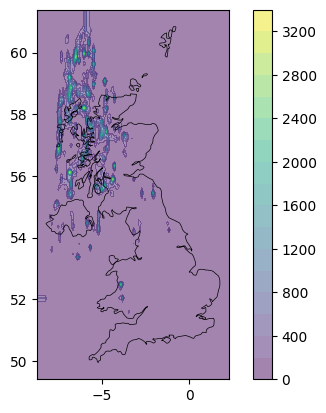

In [24]:
uk_outline()
xmin, xmax = plt.gca().get_xlim()
ymin, ymax = plt.gca().get_ylim()
mx, my = np.mgrid[xmin:xmax:0.1, ymin:ymax:0.1]

sampling_interp = sampling_model.predict(np.c_[mx.reshape(-1), my.reshape(-1)]).reshape(mx.shape)
# sampling_interp =(mx.reshape(-1)+ my.reshape(-1)).reshape(mx.shape)
plt.contourf(sampling_interp, extent=[xmin, xmax, ymin, ymax], cmap="viridis", alpha=0.5, levels=20)
plt.colorbar()

0.48484848484848486

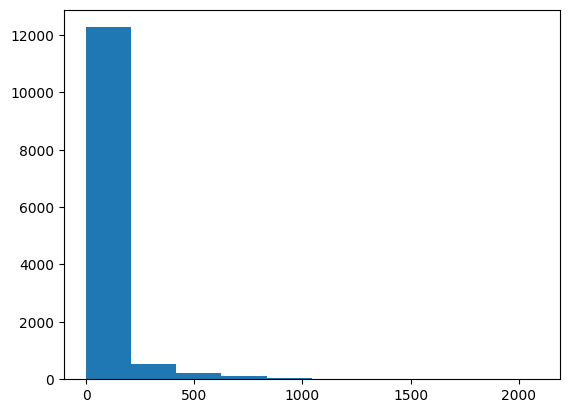

In [10]:
plt.hist(sampling_interp.flatten())
(sampling_interp == sampling_interp[0]).mean()